In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from collections import Counter

## Data Preprocessing Functions

In [129]:
def load_and_preprocess_data(file_path):
    print("Loading data from:", file_path)
    data = pd.read_csv(file_path)
    # print("Data loaded successfully. First few rows:\n", data.head())
    
    ids = data.iloc[:, 0]
    features = data.iloc[:, 1:].values  # Extract feature values
    # print("Extracted IDs and features. IDs:\n", ids.head())
    
    # Load the dataset with max_diameter information
    ascending_df = pd.read_csv("/home/hongwcai/LSS/ECE5995_AorticWall/Data/measures/Ascending.csv")
    # print("Loaded ascending_df. First few rows:\n", ascending_df.head())
    
    # Categorize diameters based on max_diameter
    ascending_df['group'] = ascending_df['max_diameter'].apply(categorize_diameter)
    # print("Categorized diameters. First few rows with group:\n", ascending_df.head())
    
    # Create a mapping from ID to the diameter category
    id_to_group = dict(zip(ascending_df.iloc[:, 0].astype(str), ascending_df['group']))
    # print("Created ID to group mapping. Sample mapping:\n", list(id_to_group.items())[:5])
    
    # Categorize the first column of feature data (assumed to be diameter)
    labels = np.array([id_to_group.get(value, 'Unknown') for value in ids])
    # print("Categorized labels based on IDs. Labels:\n", labels[:10])
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    # print("Standardized features. First few rows:\n", scaled_features[:5])

    return scaled_features, labels, data.columns[1:]

# Categorize diameter in mm
def categorize_diameter(value):
    if value < 45:
        return 0
    elif 45 <= value < 50:
        return 1
    elif 50 <= value < 55:
        return 2
    else:
        return 3

## PCA Functions

In [130]:
def perform_pca(scaled_features, n_components=21):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_features)
    return pca_data, pca

def plot_explained_variance(pca, feature_name):
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--', label="Explained Variance")
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Cumulative Explained Variance ({feature_name})')
    plt.legend()
    plt.grid()
    plt.show()

def plot_pca_heatmap(pca, feature_names, feature_name):
    plt.figure(figsize=(10, 6))
    sns.heatmap(pca.components_, cmap='viridis', xticklabels=feature_names, 
                yticklabels=[f'PC{i+1}' for i in range(len(pca.components_))])
    plt.xlabel('Original Features')
    plt.ylabel('Principal Components')
    plt.title(f'PCA Feature Loadings ({feature_name})')
    plt.legend(["Feature Contribution"])
    plt.show()

def plot_pca_2d(pca_data, labels, feature_name):
    colors = {0: "blue", 1: "green", 2: "orange", 3: "red"}
    class_labels = {0: "<45mm", 1: "[45,50)mm", 2: "[50,55)mm", 3: "≥55mm"}

    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(pca_data[idx, 0], pca_data[idx, 1], label=class_labels[label], color=colors[label], alpha=0.7)

    # Manually add legend entries for all categories
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=class_labels[i]) for i in range(4)]
    # plt.legend(title="Diameter Category", handles=handles, loc="upper right")
    
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(f"2D PCA Visualization ({feature_name})")
    plt.legend(title="Diameter Category", loc="upper right")
    plt.grid()
    plt.show()

## Model Training and Evaluation

In [131]:
def train_multiclass_logistic_regression(pca_data, labels, feature_name):
    # Check class distribution before splitting
    # print(f"\nClass Distribution ({feature_name}):", Counter(labels))

    X_train, X_test, y_train, y_test = train_test_split(
        pca_data[:, :2], labels, test_size=0.3, random_state=42, stratify=labels
    )

    # Check again after splitting
    # print(f"Training Class Distribution: {Counter(y_train)}")
    # print(f"Testing Class Distribution: {Counter(y_test)}")

    model = LogisticRegression(solver='lbfgs', max_iter=500)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nLogistic Regression Accuracy for {feature_name}: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

## Main Loop for PCA and Logistic Regression


### Running PCA for Diameter ###

Loading data from: /home/hongwcai/LSS/ECE5995_AorticWall/Data/measures/AscendingProfile_Diameter.csv


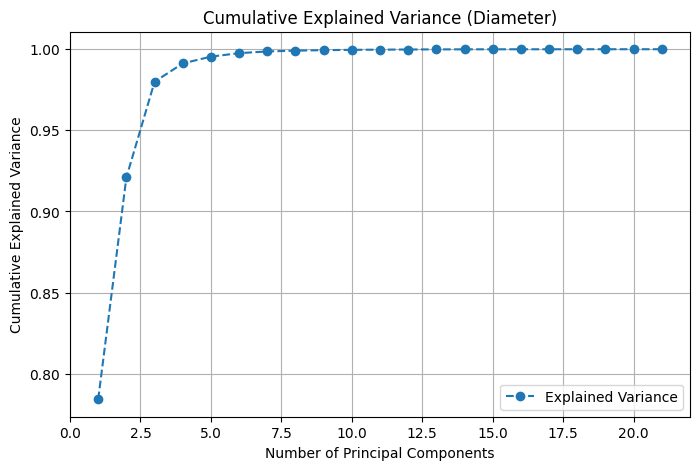

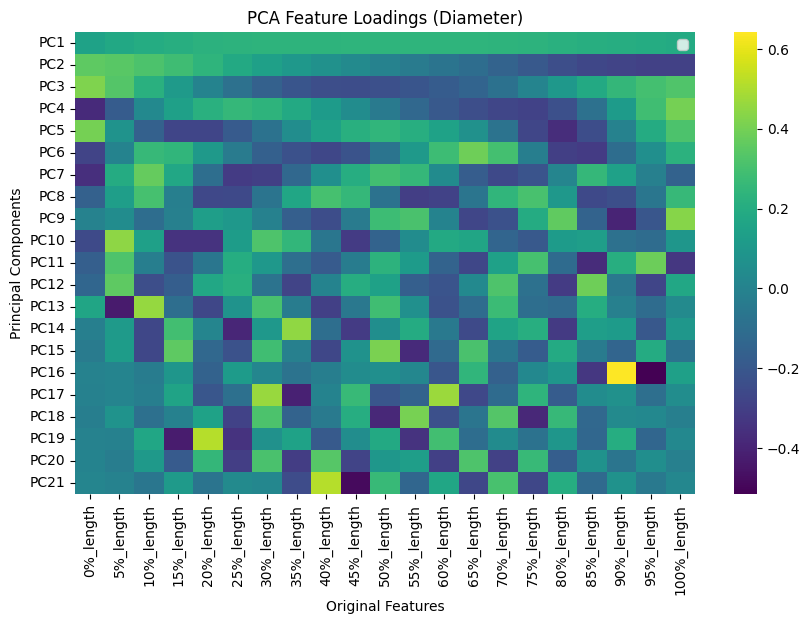

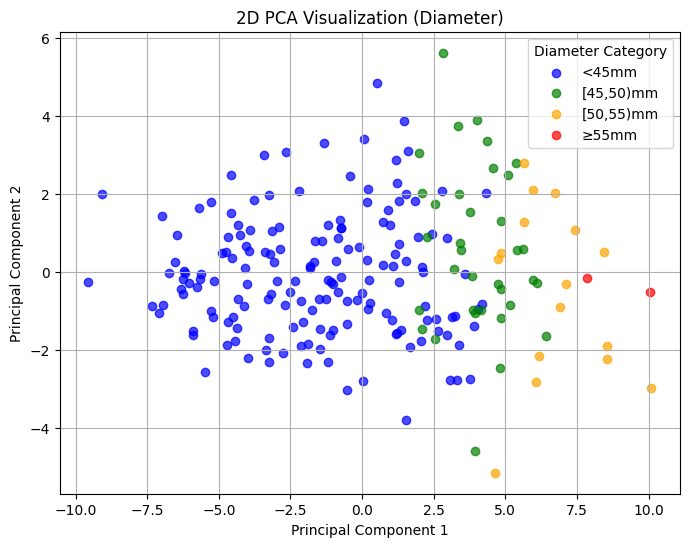


Logistic Regression Accuracy for Diameter: 0.8308

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94        49
           1       0.50      0.80      0.62        10
           2       0.50      0.20      0.29         5
           3       0.00      0.00      0.00         1

    accuracy                           0.83        65
   macro avg       0.49      0.48      0.46        65
weighted avg       0.84      0.83      0.82        65


### Running PCA for Scaled Diameter ###

Loading data from: /home/hongwcai/LSS/ECE5995_AorticWall/Data/measures/AscendingProfile_ScaledDiameter.csv


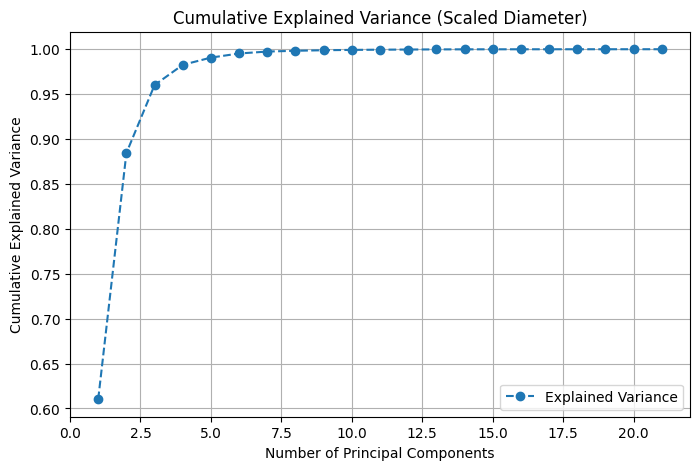

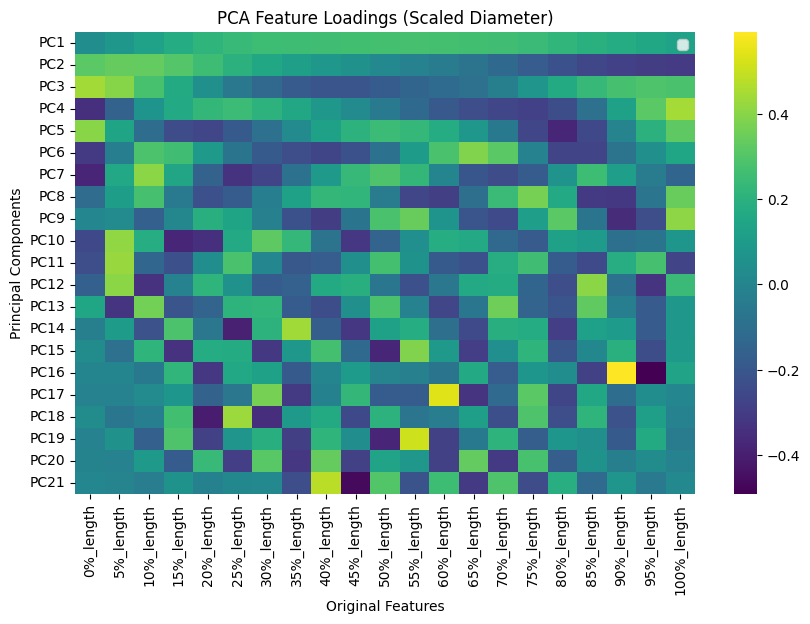

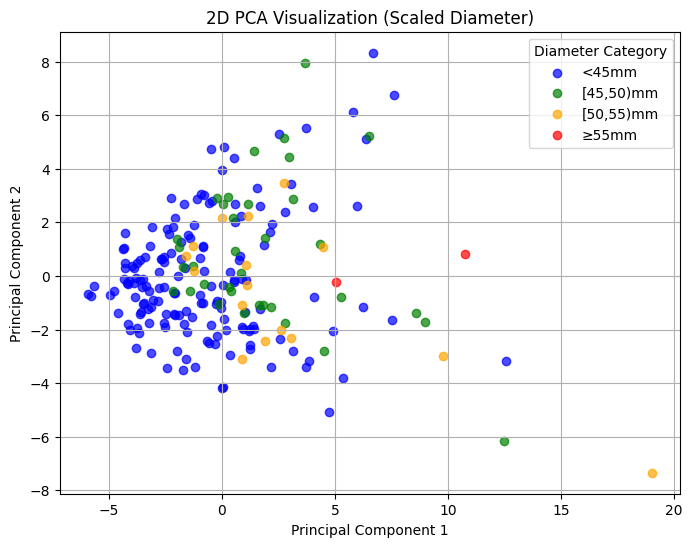


Logistic Regression Accuracy for Scaled Diameter: 0.7231

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.85        49
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         1

    accuracy                           0.72        65
   macro avg       0.19      0.24      0.21        65
weighted avg       0.58      0.72      0.64        65


### Running PCA for Eccentricity ###

Loading data from: /home/hongwcai/LSS/ECE5995_AorticWall/Data/measures/AscendingProfile_Eccentricity.csv


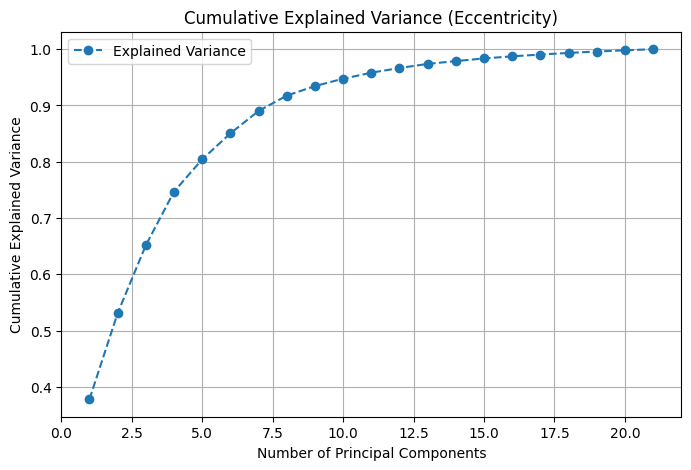

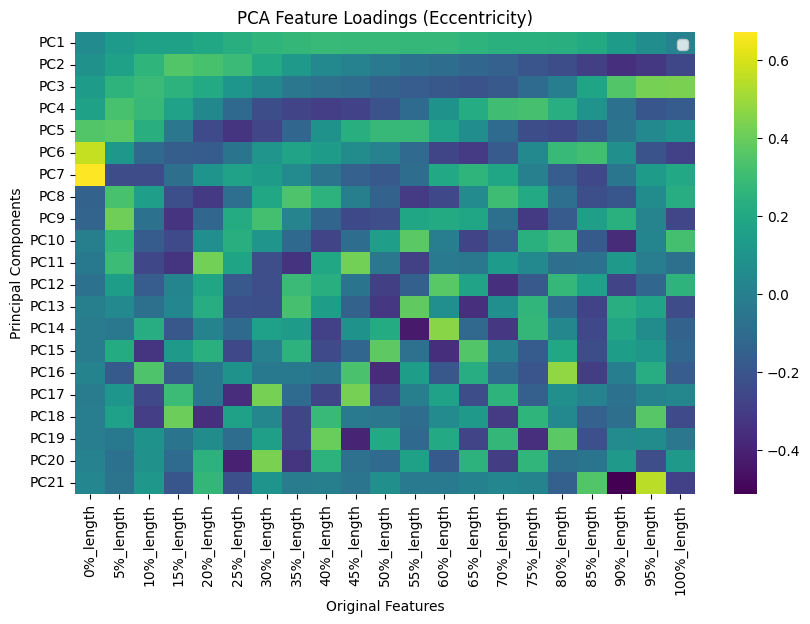

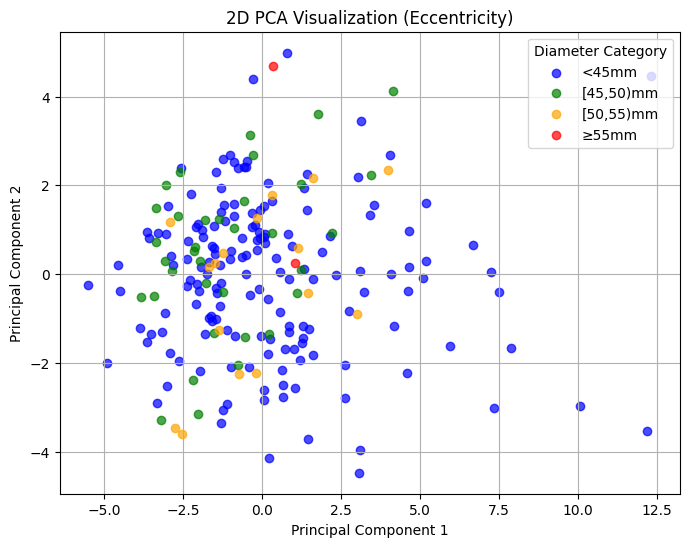


Logistic Regression Accuracy for Eccentricity: 0.7538

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86        49
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         1

    accuracy                           0.75        65
   macro avg       0.19      0.25      0.21        65
weighted avg       0.57      0.75      0.65        65


### Running PCA for Centerline Curvature ###

Loading data from: /home/hongwcai/LSS/ECE5995_AorticWall/Data/measures/AscendingProfile_CenterlineCurvature.csv


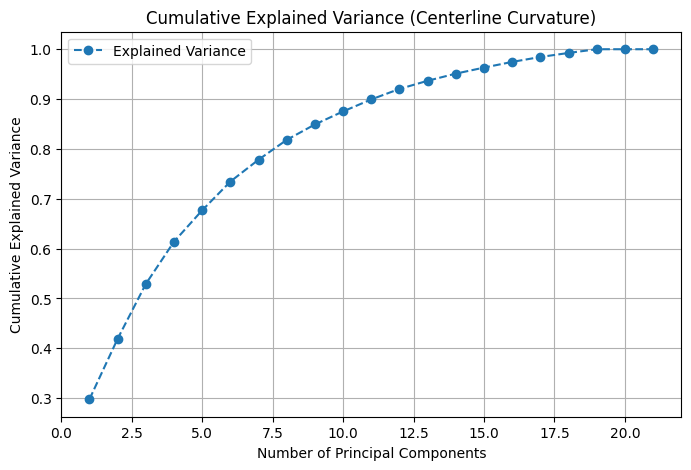

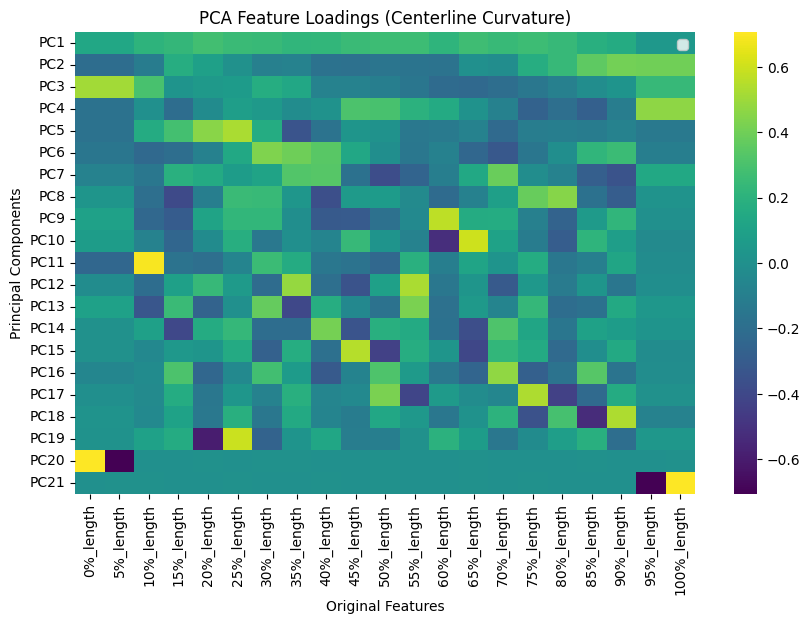

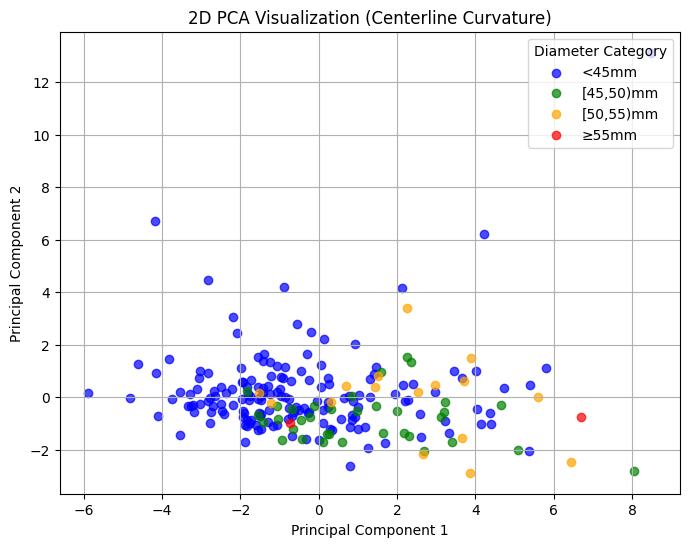


Logistic Regression Accuracy for Centerline Curvature: 0.7692

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        49
           1       0.25      0.10      0.14        10
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         1

    accuracy                           0.77        65
   macro avg       0.26      0.28      0.26        65
weighted avg       0.64      0.77      0.69        65



In [132]:
# Define file paths for different measures
file_paths = {
    "Diameter": "/home/hongwcai/LSS/ECE5995_AorticWall/Data/measures/AscendingProfile_Diameter.csv",
    "Scaled Diameter": "/home/hongwcai/LSS/ECE5995_AorticWall/Data/measures/AscendingProfile_ScaledDiameter.csv",
    "Eccentricity": "/home/hongwcai/LSS/ECE5995_AorticWall/Data/measures/AscendingProfile_Eccentricity.csv",
    "Centerline Curvature": "/home/hongwcai/LSS/ECE5995_AorticWall/Data/measures/AscendingProfile_CenterlineCurvature.csv"
}

for feature_name, file_path in file_paths.items():
    print(f"\n### Running PCA for {feature_name} ###\n")
    
    # Step 1: Load and preprocess the data
    scaled_features, labels, feature_columns = load_and_preprocess_data(file_path)
    
    # Step 2: Perform PCA
    pca_data, pca = perform_pca(scaled_features)
    
    # Step 3: Visualize PCA results
    plot_explained_variance(pca, feature_name)
    plot_pca_heatmap(pca, feature_columns, feature_name)
    plot_pca_2d(pca_data, labels, feature_name)
    
    # Step 4: Train Multiclass Logistic Regression
    train_multiclass_logistic_regression(pca_data, labels, feature_name)